In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [93]:
def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    if labels is not None:
        labels = labels.reshape(-1)
    cols,marks = ["red", "green", "blue", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

In [94]:
def halfmoon(n_samples, epsilon):
  pts = np.linspace(0,180, n_samples//2)* np.pi / 180
  haut = np.hstack((np.cos(pts).reshape((-1,1)), np.sin(pts).reshape((-1,1))))
  bas = np.hstack((1-np.cos(pts).reshape((-1,1)), 0.5-np.sin(pts).reshape((-1,1))))
  data = np.vstack((haut,bas))
  data[:,0]+=np.random.normal(0,epsilon,n_samples)
  data[:,1]+=np.random.normal(0,epsilon,n_samples)
  y = np.zeros(n_samples)
  y[n_samples//2:]=1
  return data, y

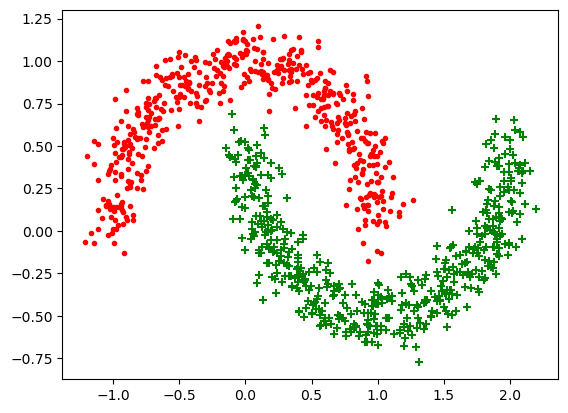

In [95]:
#Param
nbex = 1000
epsilon = 0.1

# x, y = make_moons(n_samples=nbex, noise=noise)
data, y = halfmoon(nbex, epsilon)
plot_data(data, y)

## Preparation de données

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
idx = np.arange(len(y))
idx_train_val, idx_test = train_test_split(idx, test_size=0.2, shuffle = True)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, shuffle = True)
data_train = data[idx_train]
data_val = data[idx_val]
data_test = data[idx_test]

y_train = y[idx_train]
y_val = y[idx_val]
y_test = y[idx_test]

In [98]:
def makeData(n_samples, epsilon):
    data, y = halfmoon(n_samples, epsilon)
    idx = np.arange(len(y))
    idx_train, idx_test = train_test_split(idx, test_size=0.2, shuffle = True)

    data_train = data[idx_train]
    data_test = data[idx_test]
    y_train = y[idx_train]
    y_test = y[idx_test]

    return data_train, y_train, data_test, y_test


## Apprentissage

In [99]:
from sklearn.svm import LinearSVC

In [100]:
clf = LinearSVC()
clf.fit(data_train, y_train)

/Users/son/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [101]:
from sklearn.metrics import accuracy_score

In [102]:
y_pred_val = clf.predict(data_val)
accuracy_score(y_val, y_pred_val)

0.85625

## Algorithme Growing Spheres

In [103]:
def generate_SL(x, ray1, ray2, n):
  d = x.shape[0]
  z = np.random.multivariate_normal(np.zeros(d),np.diag(np.ones(d)),n)
  z = (z/(np.linalg.norm(z, axis=1)).reshape((-1,1)))
  u = np.random.uniform(ray1**d, ray2**d, n)
  u = u**(1/d)
  u = u.reshape((-1,1))
  x_new = x+z*u
  return x_new

In [104]:
x = data[np.random.randint(nbex)]
x_new = generate_SL(x,2,4,100)

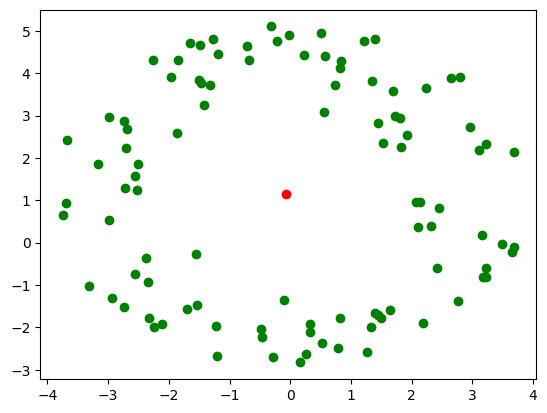

In [105]:
plt.scatter(x[0],x[1], color="red")
plt.scatter(x_new[:,0],x_new[:,1], color="green")
plt.show()

In [106]:
def GSG(clf, x, etha, n):
  """
    Params:
      clf : le classifieur
      x   : la données à expliquer
      etha: hyperparametre, le rayon de recherche de l'algo
      n   : hyperparametre, le nombre de données générées à chaque itération de l'algo
  """
  f_x = clf.predict([x])[0]
  z = generate_SL(x,0,etha,n)

  while (clf.predict(z)==f_x).sum()!=n:
    etha /=2
    z = generate_SL(x,0,etha,n)

  a0 = etha
  a1 = 2*etha

  while (clf.predict(z)==f_x).sum()==n:
    z = generate_SL(x,a0,a1,n)
    a0 = a1
    a1 += etha
  z = z[clf.predict(z)!=f_x]
  idx_min = np.argmin(np.linalg.norm(x-z, axis=1))
  return z[idx_min]

def GSFS(clf, x, etha, n):
  """
    Params:
      clf : le classifieur
      x   : la données à expliquer
      etha: hyperparametre, le rayon de recherche de l'algo
      n   : hyperparametre, le nombre de données générées à chaque itération de l'algo
  """
  f_x = clf.predict([x])
  e = GSG(clf, x, etha, n)
  e_tmp = np.copy(e)
  e_target = None
  while clf.predict([e_tmp]) != f_x:
    e_target = np.copy(e_tmp) #deep copy ici
    features_idx = np.where(e_tmp!=x)[0]
    i = features_idx[np.argmin(np.abs(e_tmp[features_idx]-x[features_idx]))]
    e_tmp[i] = x[i]
  return e, e_target


In [107]:
from sklearn.inspection import DecisionBoundaryDisplay

In [108]:
def visualisation_2D(data, y, clf, x, GS, etha=5, n=50) -> None:
  """
    Params:
      data: données
      y   : labels des données
      clf : un classfifier
      x   : un point de départ dont point cicle nous voulons chercher
      GS  : une fonction qui genère le point cible selon Algorithme Growing Spheres
      etha: hyperparamètre, rayon de recherche
      n   : hyperparamètre, nombre de données générés à chaque itération
  """
  disp = DecisionBoundaryDisplay.from_estimator(
      clf, data, response_method="predict",
      xlabel="X", ylabel="Y",
      alpha=0.5)

  disp.ax_.scatter(data[:, 0], data[:, 1], c=y, edgecolor="k",alpha=0.2)
  disp.ax_.scatter(x[0], x[1], color="red", label="point choisi")

  if GS.__name__ == "GSG":
    e = GS(clf, x, etha, n)
    disp.ax_.scatter(e[0], e[1], color=np.random.rand(1,3), label="cible_"+GS.__name__)
    plt.title("Growing Spheres Generation")
  else:
    e, e_modif = GS(clf, x, etha, n)
    disp.ax_.scatter(e[0], e[1], color=np.random.rand(1,3), label="cible_GSG")
    disp.ax_.scatter(e_modif[0], e_modif[1], color=np.random.rand(1,3), label="cible_GSFS")
    plt.title("Growing Spheres Feature Selection")
  plt.legend()
  plt.show()

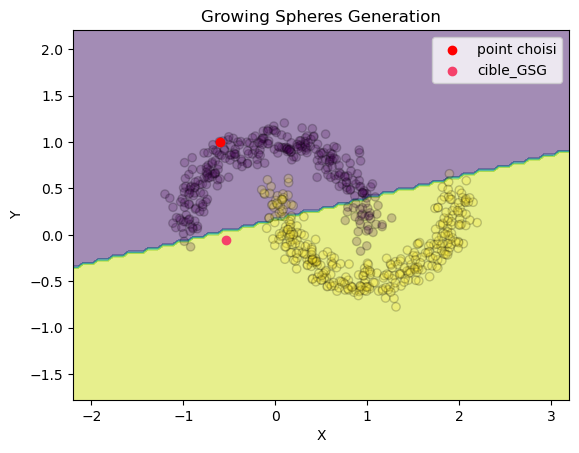

In [109]:
x = data[np.random.randint(nbex)]
GS = GSG
visualisation_2D(data_train, y_train, clf, x, GS)

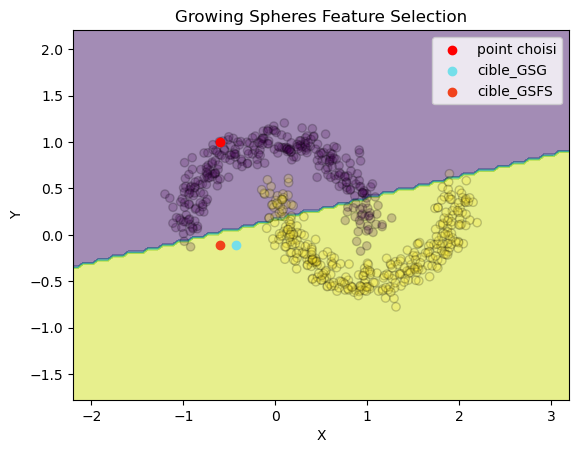

In [110]:
GS = GSFS
visualisation_2D(data_train, y_train, clf, x, GS)

## Expérimentation

### Robustesse selon classifieur utilisé

/Users/son/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/son/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/son/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/son/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` e

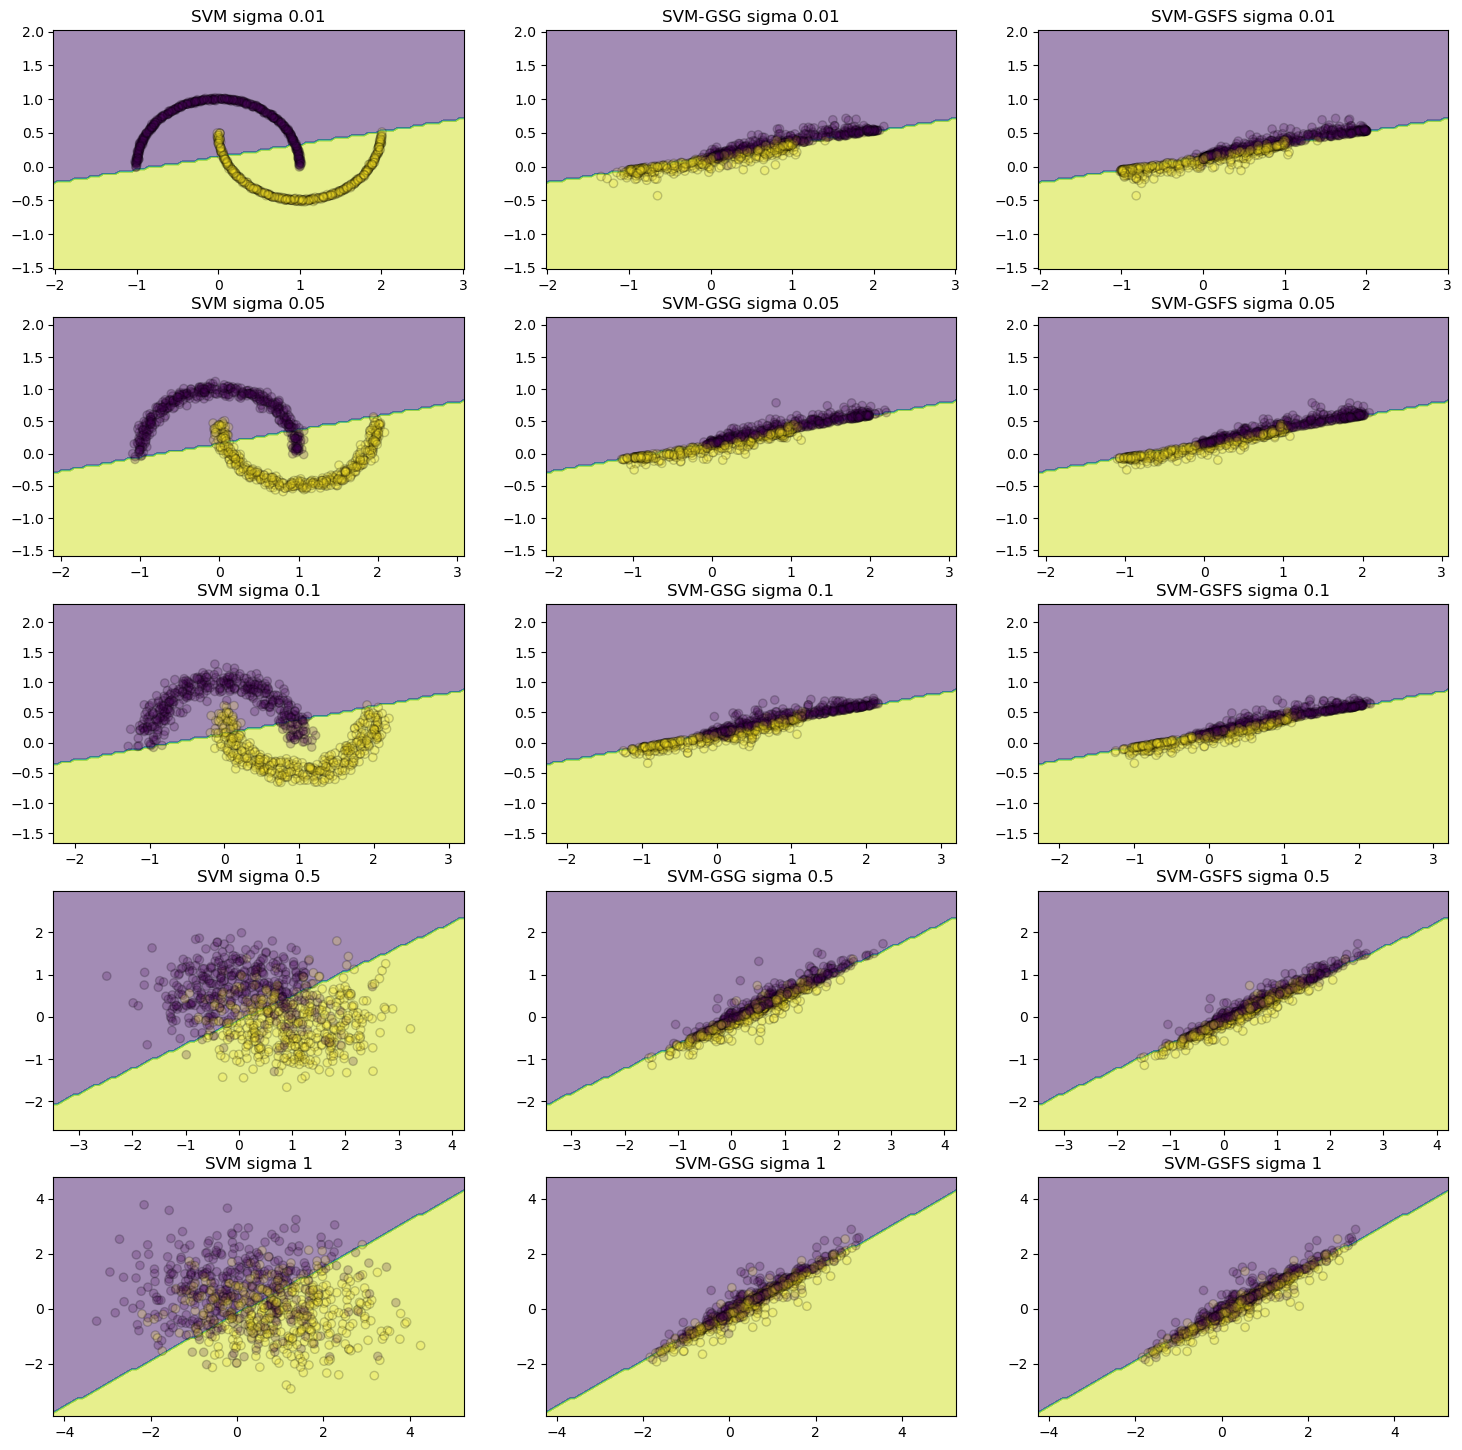

In [111]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon=[0.01, 0.05, 0.1, 0.5, 1]
nbex = 1000
clf = LinearSVC()

for eps in epsilon:
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=eps)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM sigma {epsilon[i//3]}')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM-GSG sigma {epsilon[i//3]}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM-GSFS sigma {epsilon[i//3]}')
    i+=1

In [112]:
from sklearn.ensemble import RandomForestClassifier


In [113]:
data_train, y_train, data_test, y_test = makeData(n_samples=1000, epsilon=0.03)

In [114]:
clf = RandomForestClassifier(n_estimators = 10, max_depth = 5, random_state = 1)
clf.fit(data_train, y_train)
accuracy_score(y_test, clf.predict(data_test))


0.99

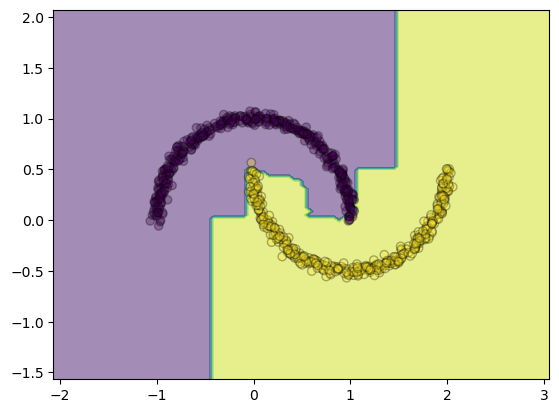

In [115]:
disp = DecisionBoundaryDisplay.from_estimator(clf,
        data_train,
        response_method="predict",
        alpha=0.5)
disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train,edgecolor="k", alpha=0.3)

### Robustesse sur la perturbation de données 

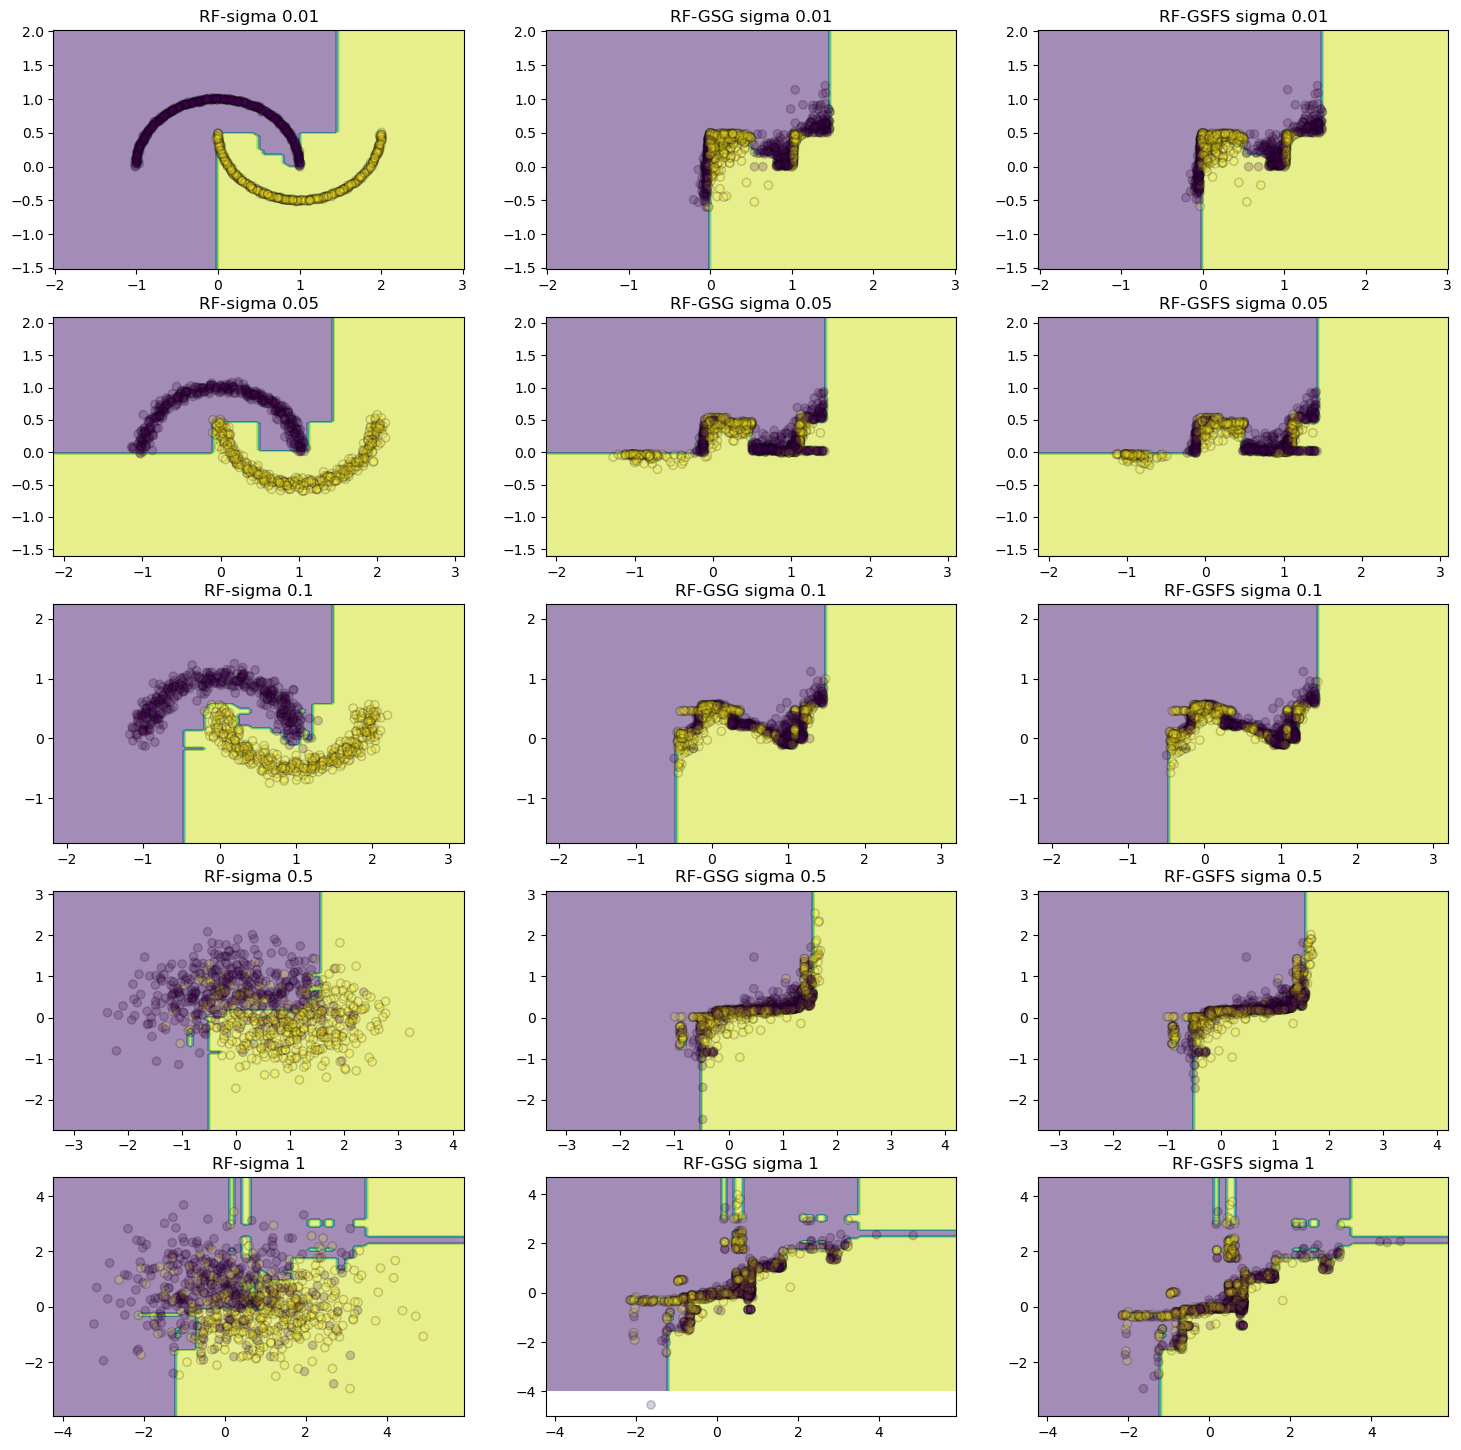

In [116]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon=[0.01, 0.05, 0.1, 0.5, 1]
nbex = 1000
clf = RandomForestClassifier(n_estimators = 10, max_depth = 5, random_state = 1)

for eps in epsilon:
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=eps)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'RF-sigma {epsilon[i//3]}')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'RF-GSG sigma {epsilon[i//3]}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'RF-GSFS sigma {epsilon[i//3]}')
    i+=1

In [117]:
from sklearn.neighbors import KNeighborsClassifier

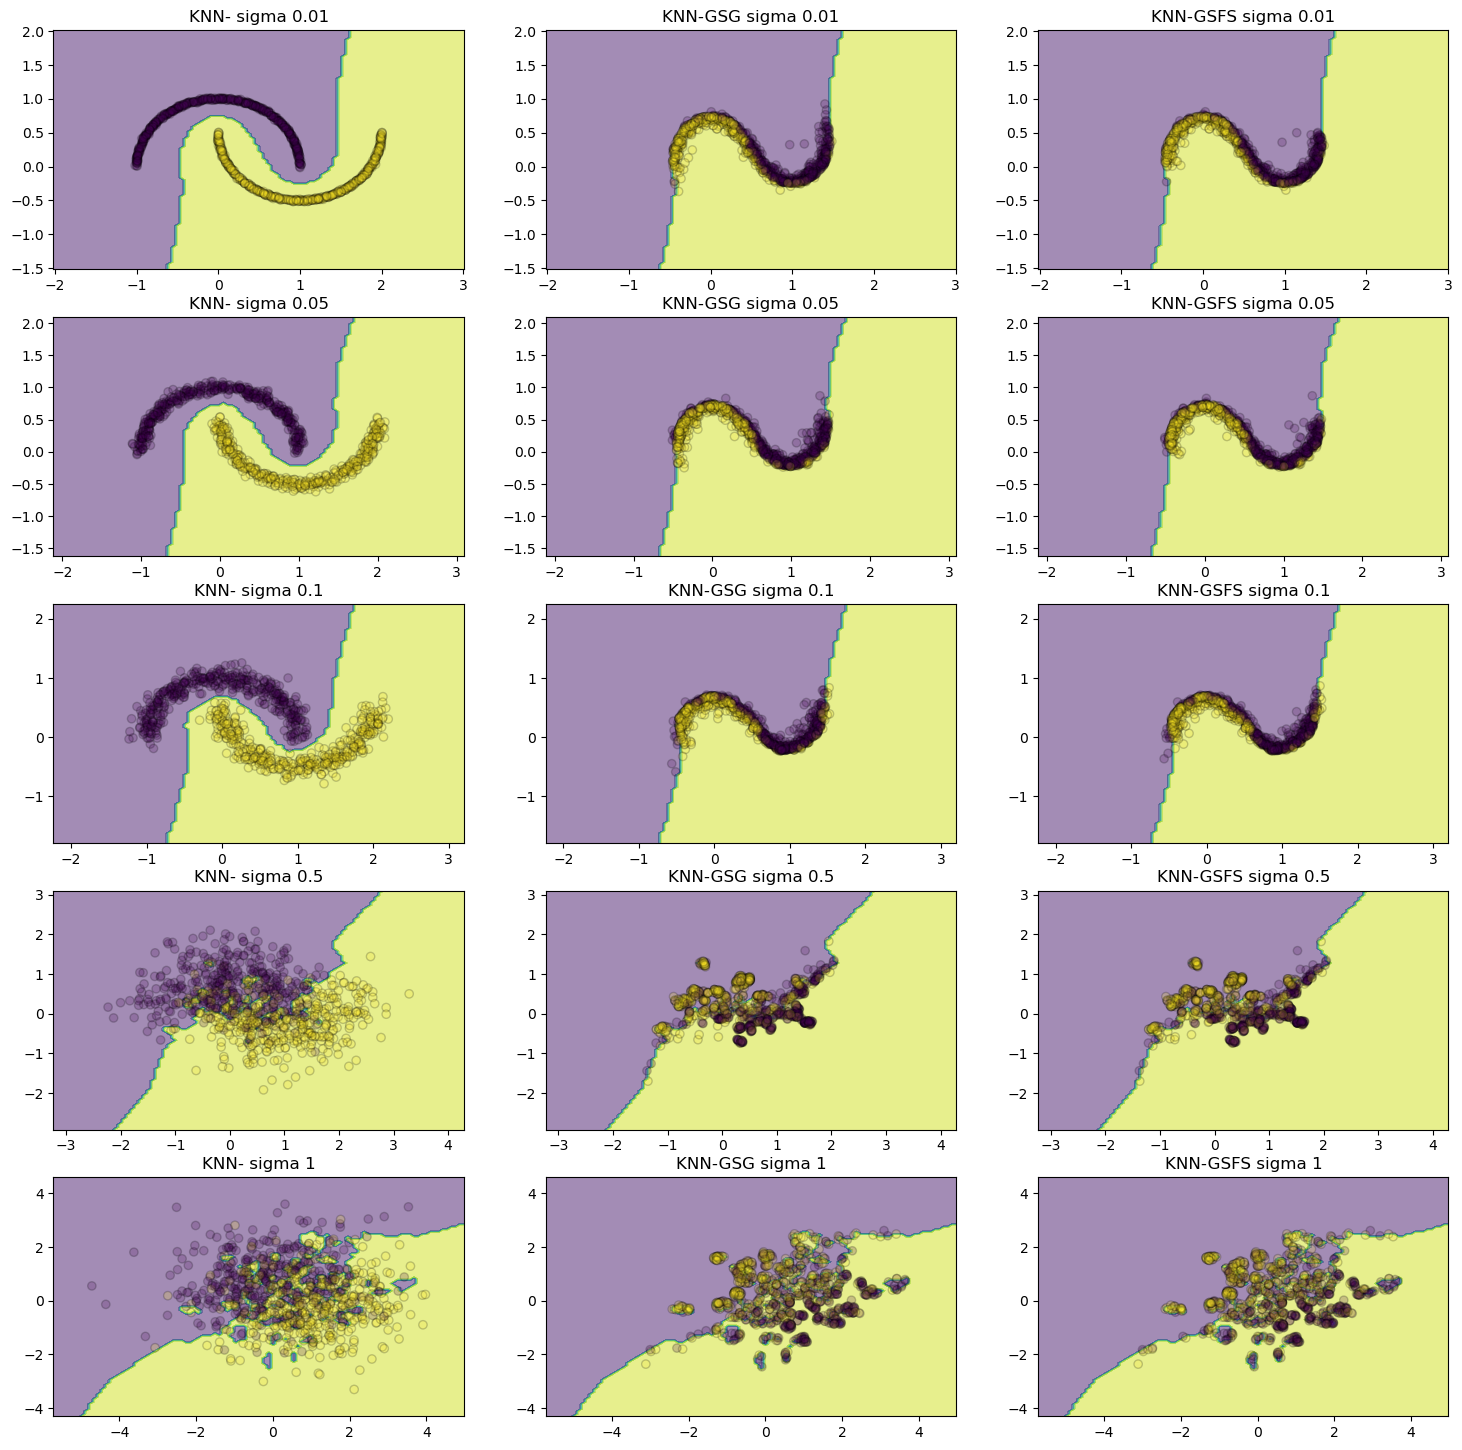

In [118]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon=[0.01, 0.05, 0.1, 0.5, 1]
nbex = 1000
clf = KNeighborsClassifier(n_neighbors=3)

for eps in epsilon:
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=eps)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'KNN- sigma {epsilon[i//3]}')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'KNN-GSG sigma {epsilon[i//3]}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'KNN-GSFS sigma {epsilon[i//3]}')
    i+=1

### Modification sur la complexité de classifieur

In [119]:
from sklearn.svm import SVC

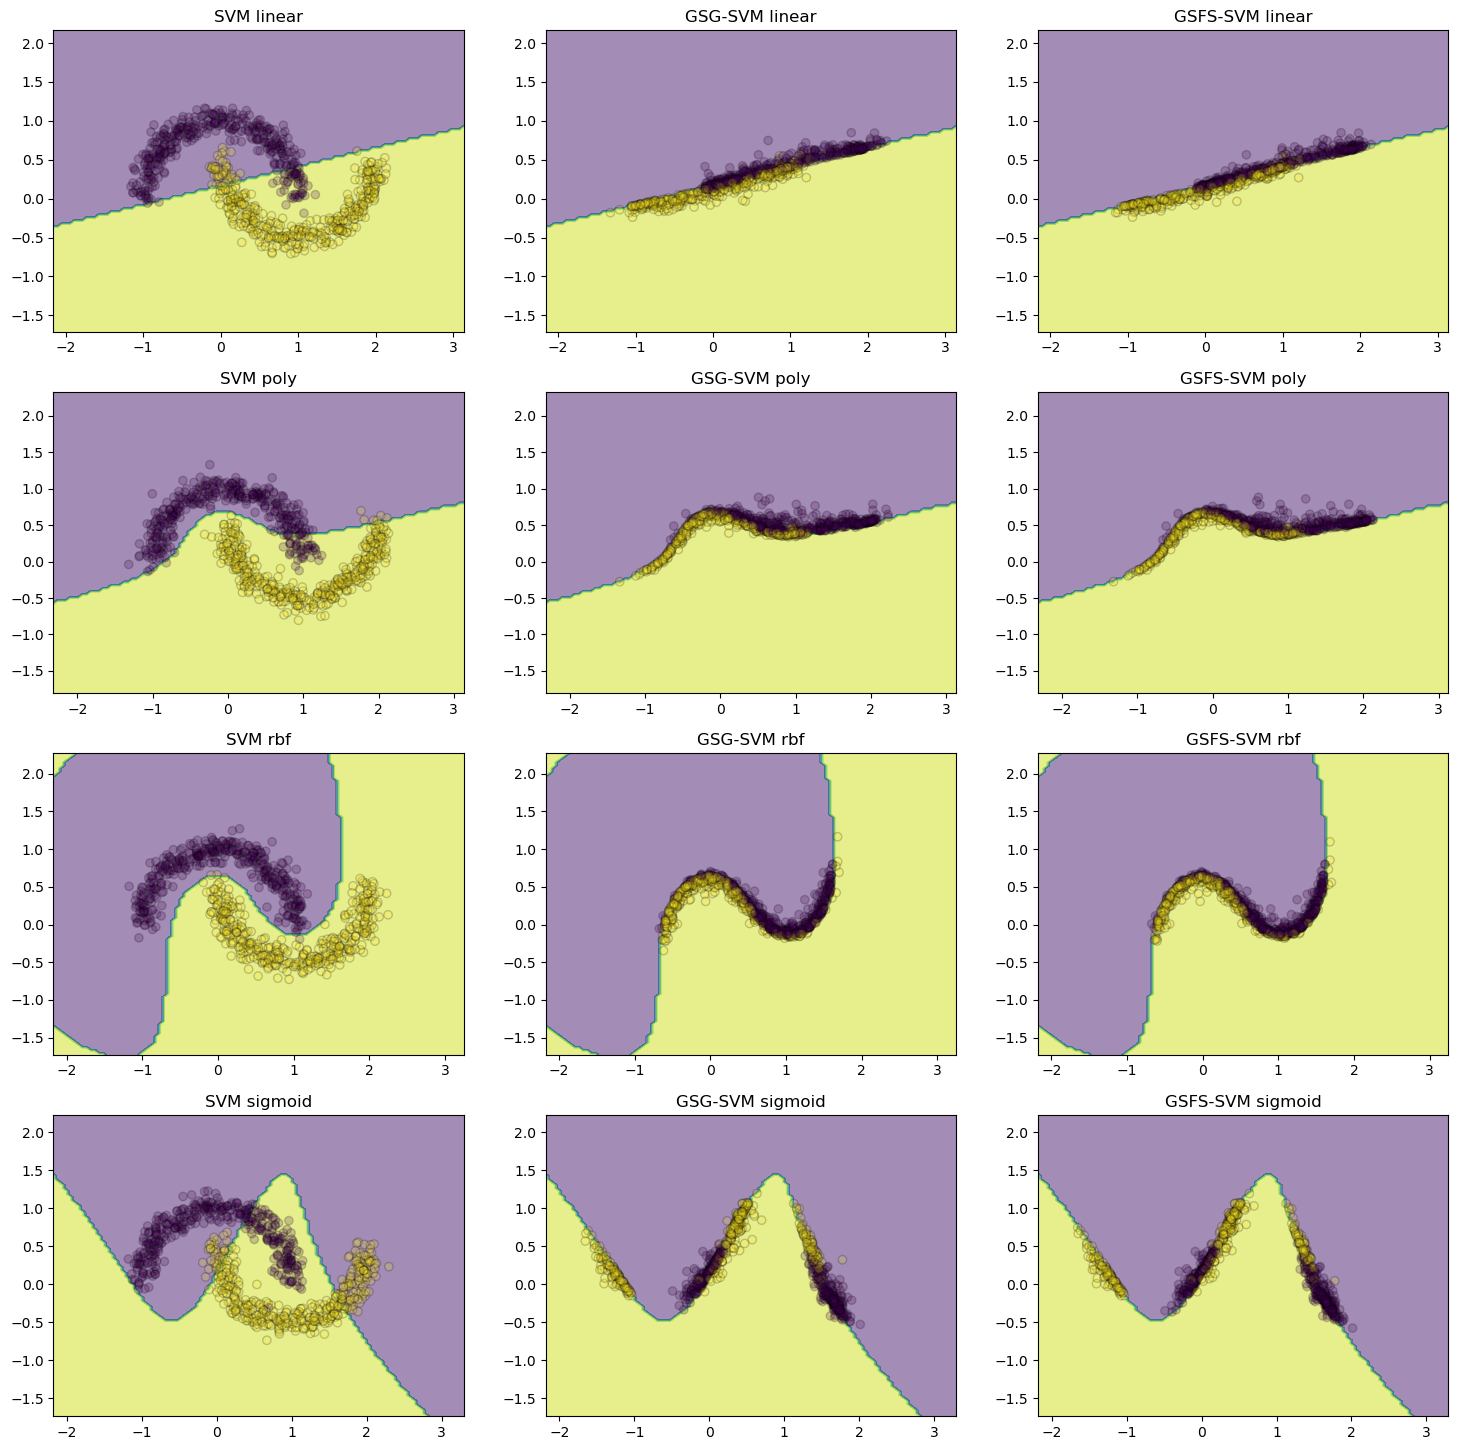

In [120]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon= 0.1
nbex = 1000
kernels = ["linear", "poly", "rbf", "sigmoid"]

for k in kernels:
    clf = SVC(kernel=k, random_state=1)
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=epsilon)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM {k}')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'GSG-SVM {k}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'GSFS-SVM {k}')
    i+=1

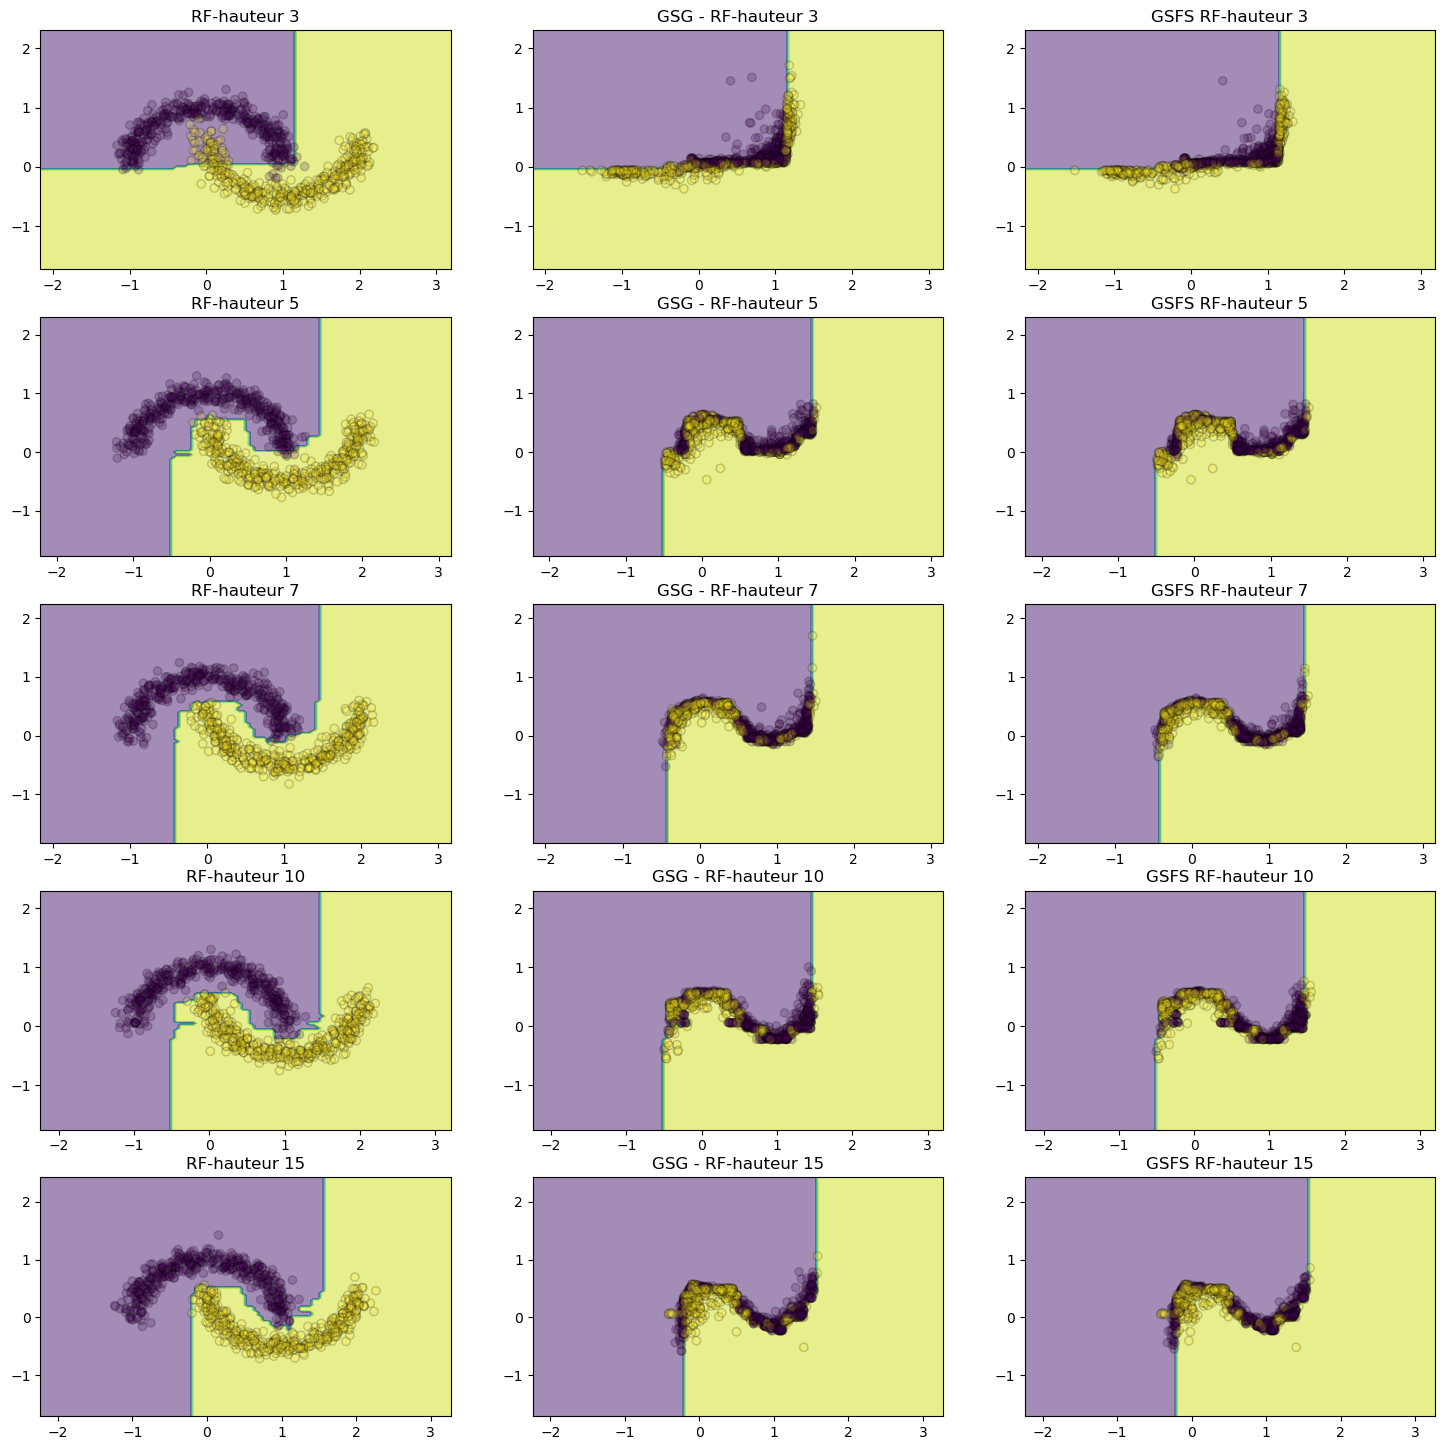

In [121]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon= 0.1
nbex = 1000
depths = [3, 5, 7, 10, 15]

for d in depths:
    clf = RandomForestClassifier(n_estimators = 10, max_depth = d, random_state = 1)
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=epsilon)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'RF-hauteur {d}')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'GSG - RF-hauteur {d}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'GSFS RF-hauteur {d}')
    i+=1

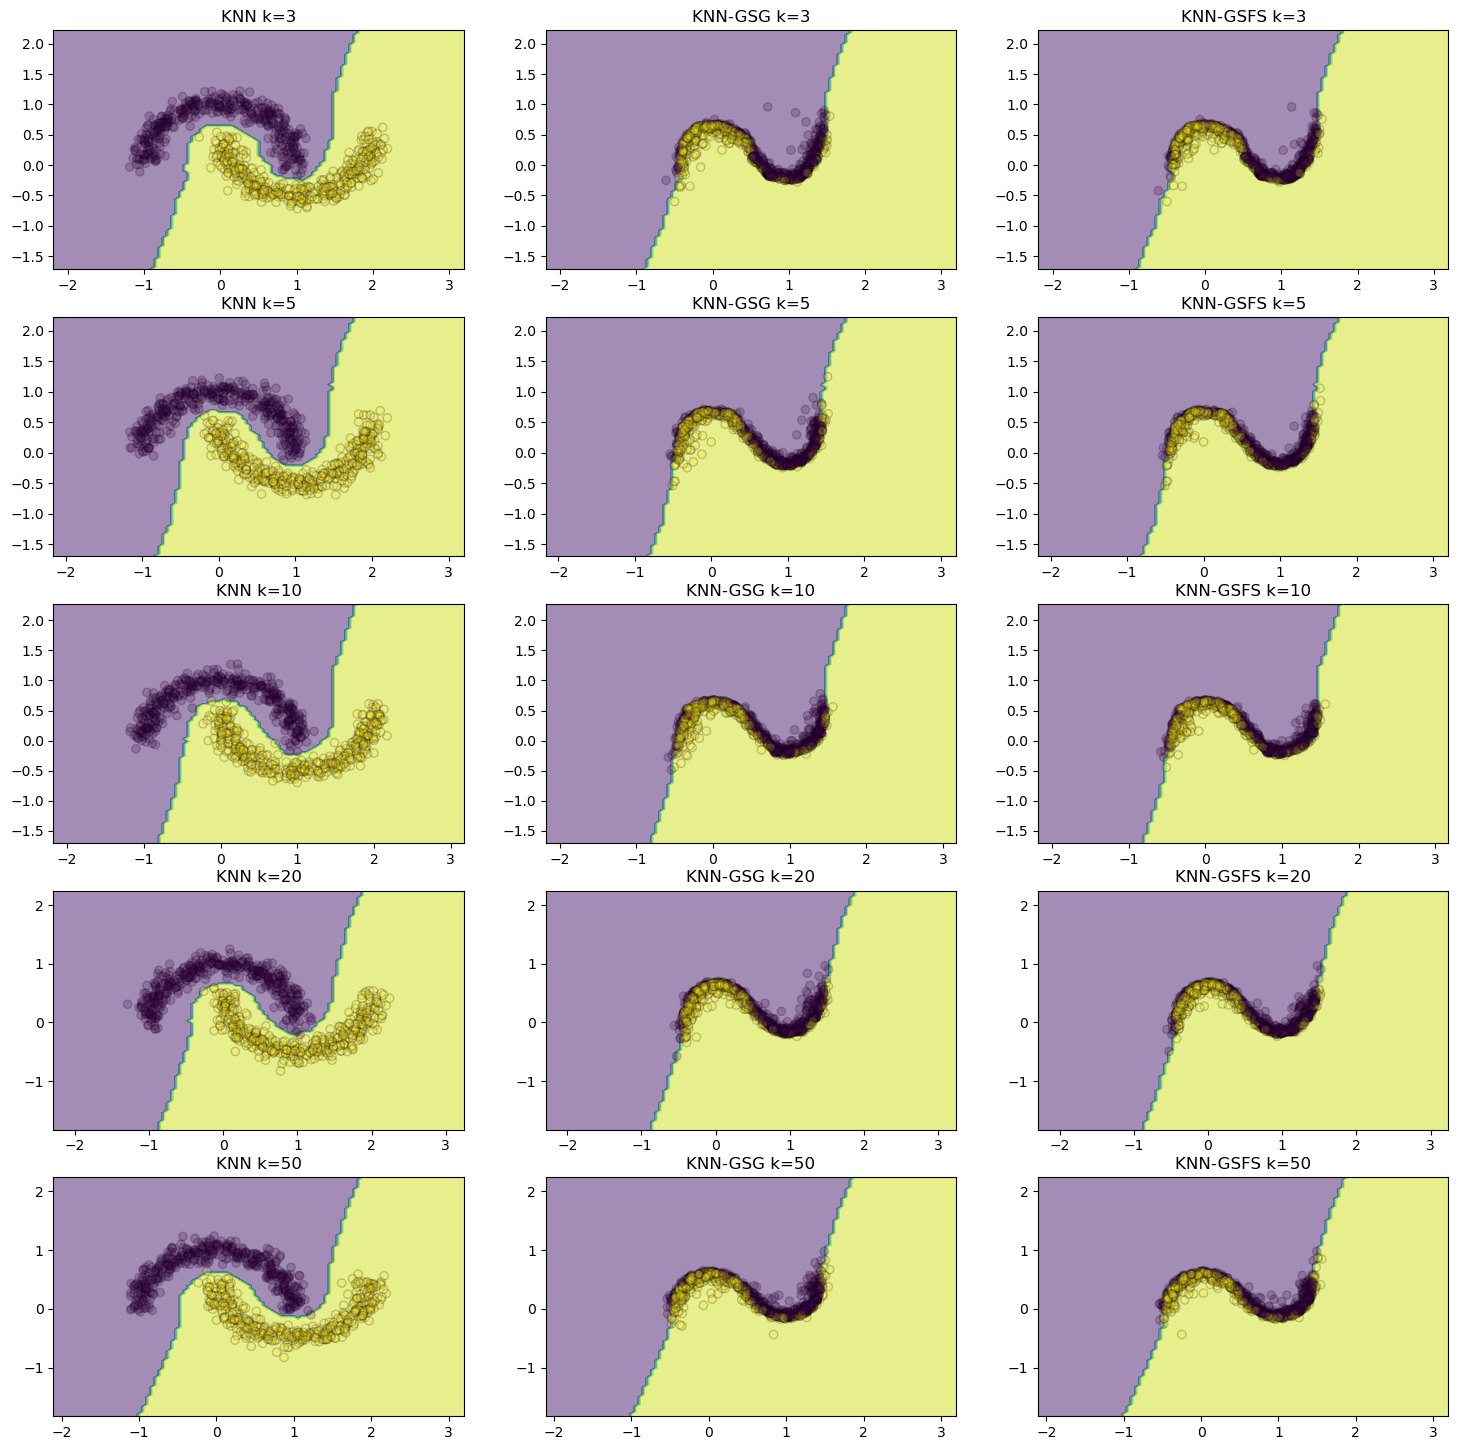

In [122]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon= 0.1
ks=[3, 5, 10, 20, 50]
nbex = 1000


for k in ks:
    #Classifieur
    clf = KNeighborsClassifier(n_neighbors=k)
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=epsilon)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'KNN k={k}')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'KNN-GSG k={k}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'KNN-GSFS k={k}')
    i+=1

### Modification les paramètres de l'algorithme

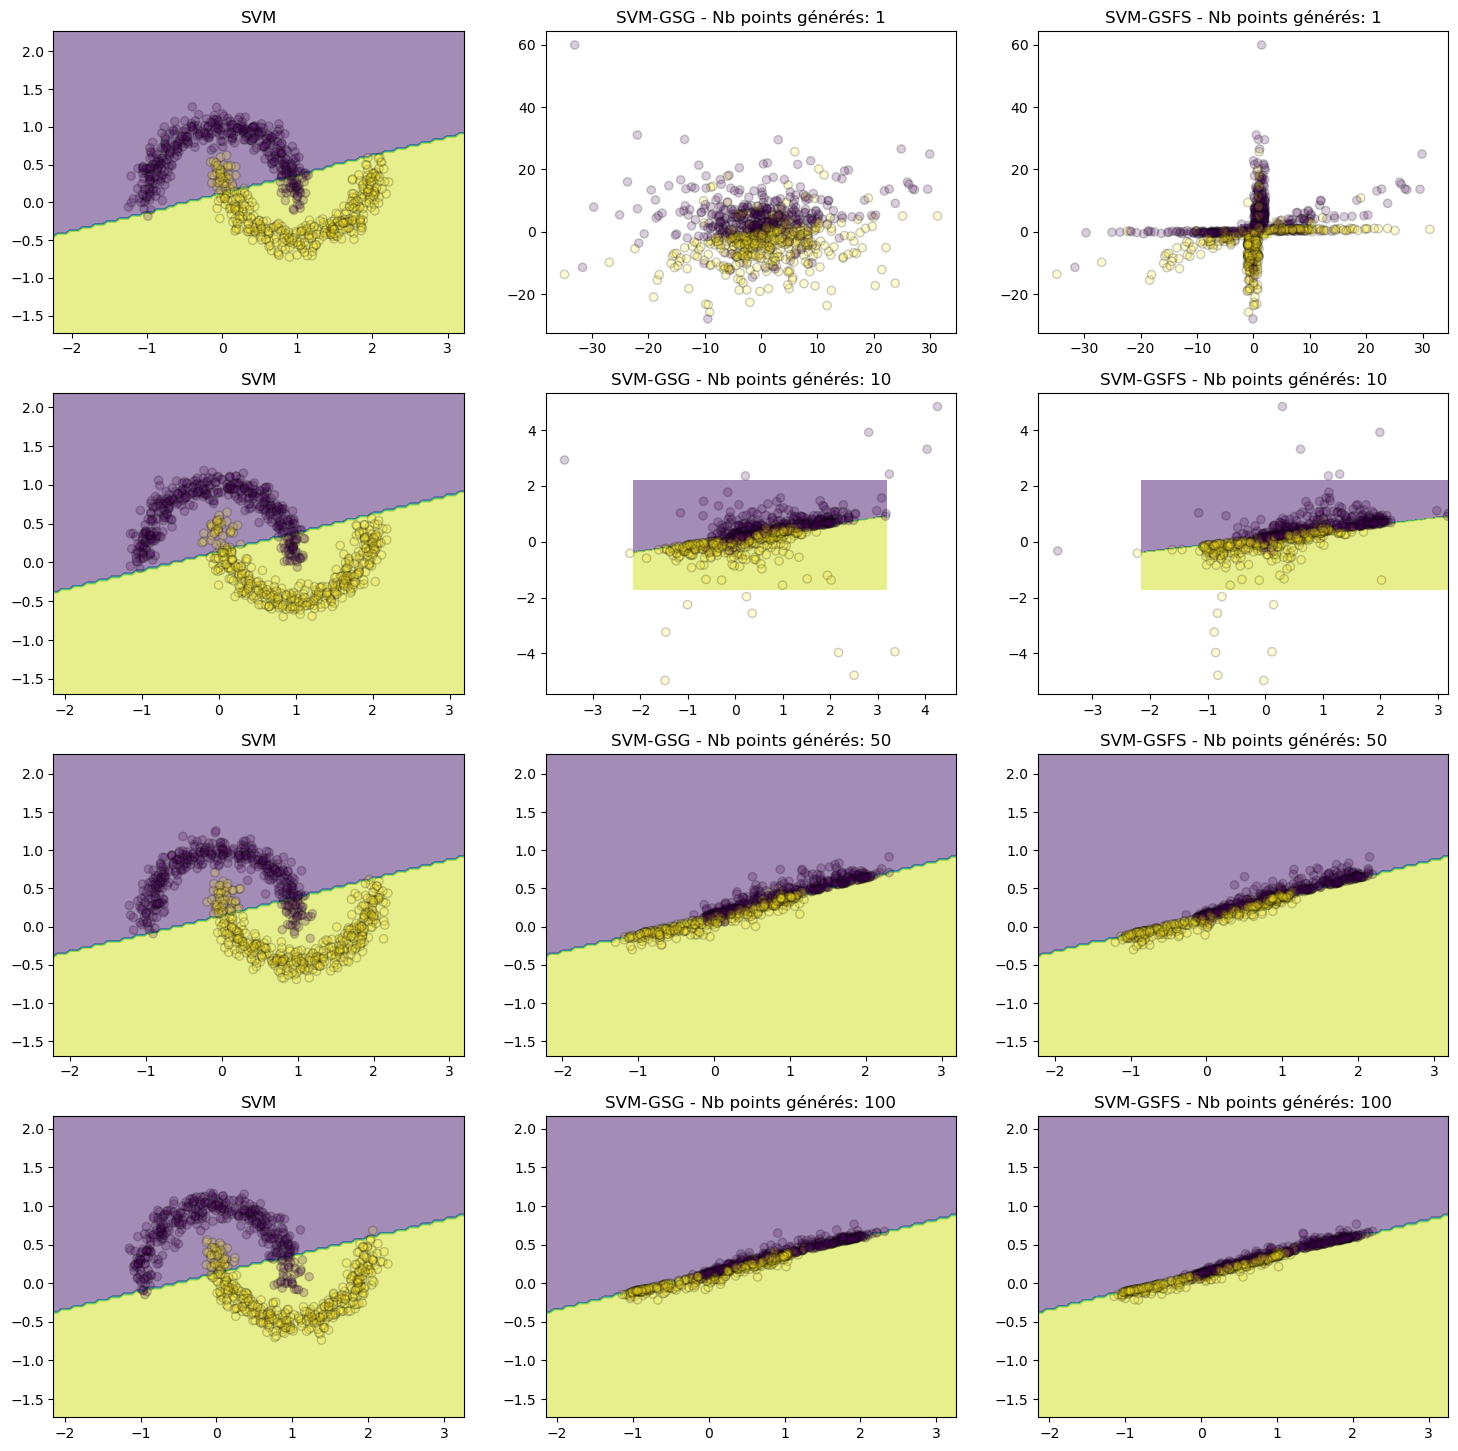

In [125]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon= 0.1
nbex = 1000
nb_gen = [1, 10, 50, 100]

for n in nb_gen:
    clf = SVC(kernel="linear", random_state=1)
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=epsilon)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=5, n=n) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM-GSG - Nb points générés: {n}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM-GSFS - Nb points générés: {n}')
    i+=1

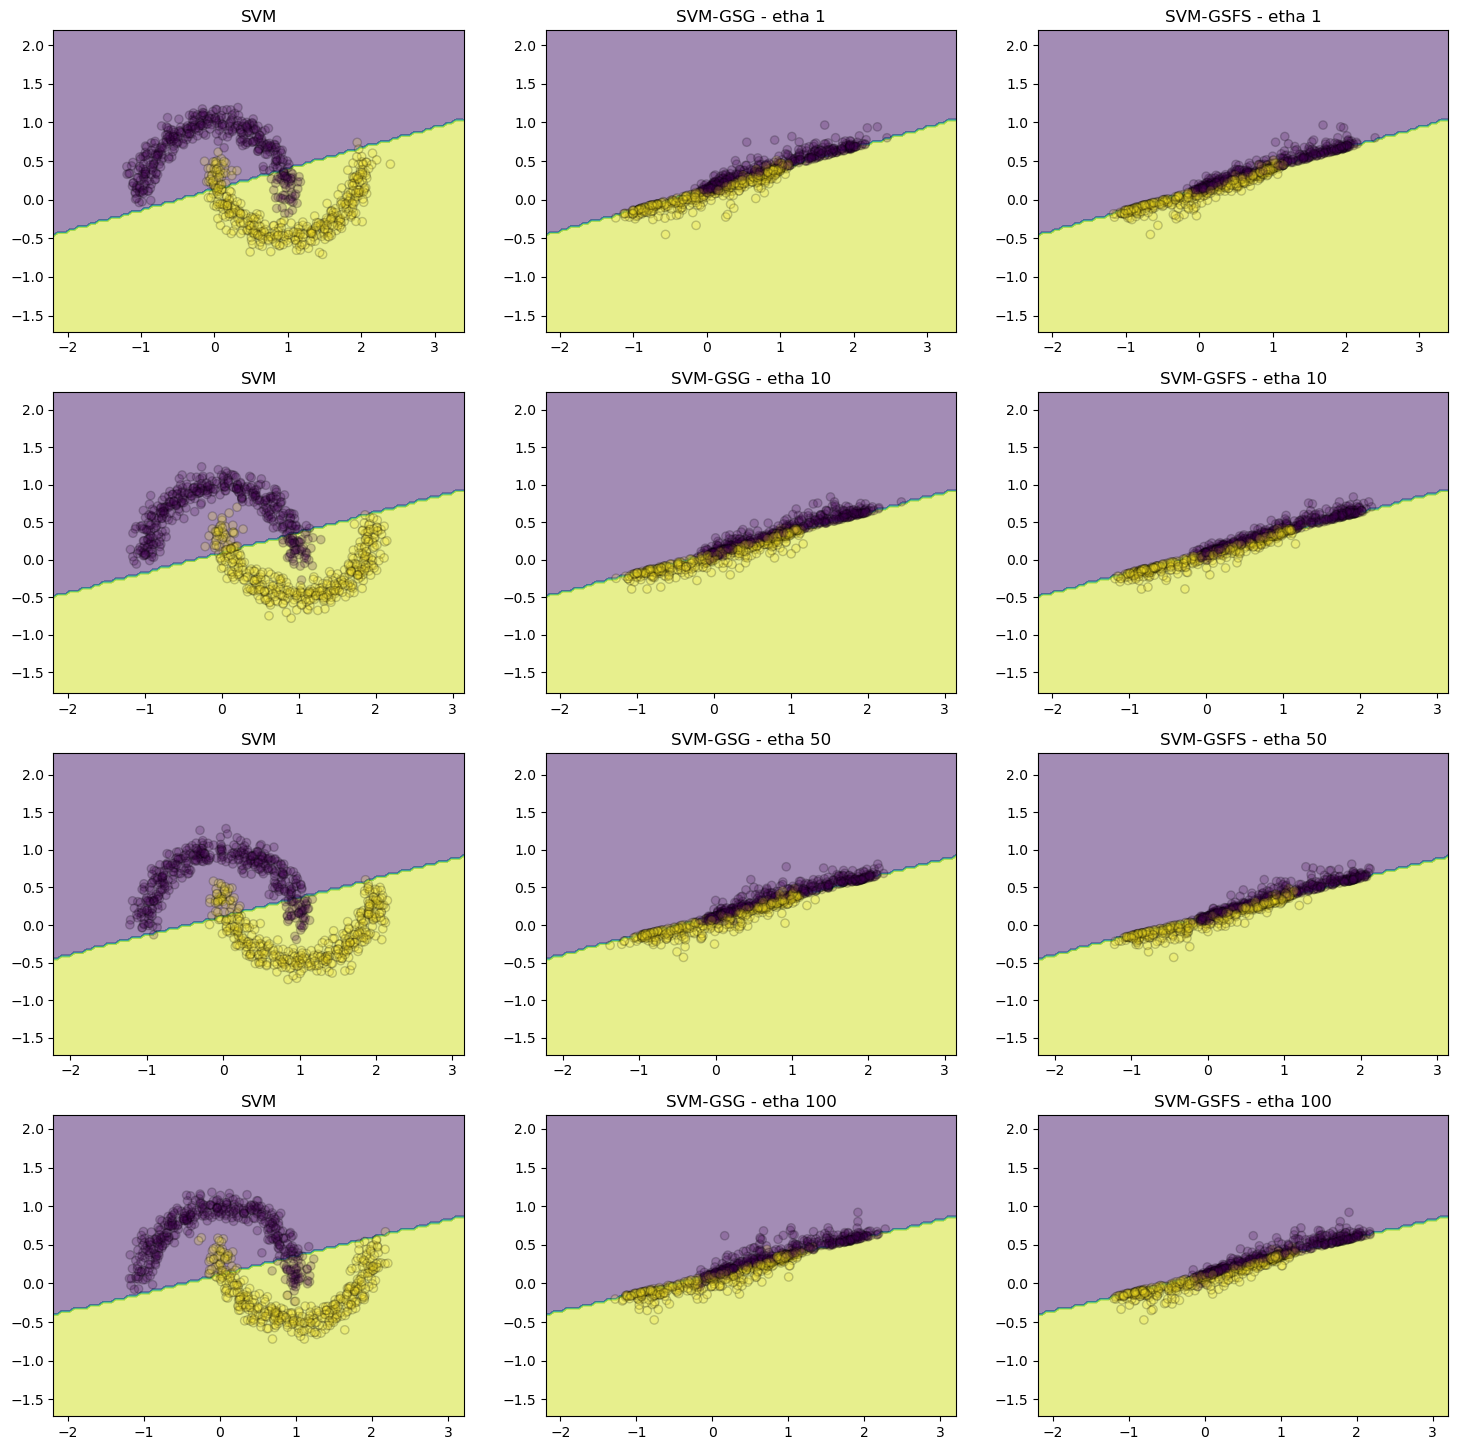

In [124]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(18,18))
ax = ax.flatten()
i = 0
epsilon= 0.1
nbex = 1000
ethas = [1, 10, 50, 100]

for etha in ethas:
    clf = SVC(kernel="linear", random_state=1)
    # Génération des données
    data_train, y_train, data_test, y_test = makeData(n_samples=nbex, epsilon=epsilon)
    clf.fit(data_train, y_train)
    
    # Affichage des données
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(data_train[:,0], data_train[:,1], c=y_train, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM')
    i+=1

    # Génération des contre-factuels
    e_cf = np.array([GSFS(clf, x, etha=etha, n=50) for x in data_train])
    y_cf = np.where(y_train==1,0, 1)
    e_GSG = e_cf[:,0]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSG[:,0], e_GSG[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM-GSG - etha {etha}')
    i+=1

    # Génération des contre-factuels GSFS
    e_GSFS = e_cf[:,1]
    # Affichage des contre-factuels
    disp = DecisionBoundaryDisplay.from_estimator(clf, 
        data_train, response_method="predict", 
        alpha=0.5, ax=ax[i])
    disp.ax_.scatter(e_GSFS[:,0], e_GSFS[:,1], c=y_cf, edgecolor="k",alpha=0.2)
    ax[i].title.set_text(f'SVM-GSFS - etha {etha}')
    i+=1